In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
n_epochs = 10
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.00003
loss_beta = 0.99
loss_running_avg = 0

In [3]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

100.1%

Extracting ./files/MNIST\raw\train-images-idx3-ubyte.gz to ./files/MNIST\raw


0.0%

113.5%

Extracting ./files/MNIST\raw\train-labels-idx1-ubyte.gz to ./files/MNIST\raw


100.4%

Extracting ./files/MNIST\raw\t10k-images-idx3-ubyte.gz to ./files/MNIST\raw


180.4%c:\python38\lib\site-packages\torchvision\datasets\mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Extracting ./files/MNIST\raw\t10k-labels-idx1-ubyte.gz to ./files/MNIST\raw
Processing...
Done!


In [4]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

Text(0.5, 1.0, 'Ground Truth: 1')

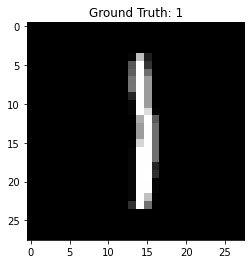

In [5]:
exampleIndex = np.random.randint(1000)
plt.imshow(example_data[exampleIndex][0], cmap='gray', interpolation='none')
plt.title("Ground Truth: {}".format(example_targets[exampleIndex]))

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 3, 5)
        self.pool = nn.MaxPool2d(2, stride=1)
        
        self.fc1 = nn.Linear(3*23*23, 16)
        self.fc2 = nn.Linear(16, 10)
        
    def forward(self, x):
        x = self.pool(self.conv1(x))
        x = x.view(-1, 3*23*23)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

In [7]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.kaiming_uniform_(m.weight)
        m.bias.data.fill_(0)

net = Net()
net.apply(init_weights)

Net(
  (conv1): Conv2d(1, 3, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1587, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=10, bias=True)
)

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)

In [ ]:
losses = []
t = 0
for epoch in range(n_epochs):
    for batch_idx, (inputs, targets) in enumerate(train_loader):        
        t += 1
        
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        
        loss_running_avg = loss_beta * loss_running_avg + (1-loss_beta) * loss.item()
        losses.append(loss_running_avg / (1 - loss_beta**t))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch #{epoch+1} Loss Running Average: {loss_running_avg}")

Epoch #1 Loss Running Average: 0.6519467448456459
Epoch #2 Loss Running Average: 0.39093879215861416
Epoch #3 Loss Running Average: 0.31397212469192115
Epoch #4 Loss Running Average: 0.2737799133963821
Epoch #5 Loss Running Average: 0.24097124975487463


In [ ]:
plt.plot(losses)

In [ ]:
accs = []
for batch_idx, (inputs, targets) in enumerate(test_loader):
    outputs = torch.argmax(net(inputs), dim=1)
    n_correct = (outputs==targets).sum().item()
    accuracy = n_correct/batch_size_test
    accs.append(accuracy)
print(f"Test Accuracy: {sum(accs)/len(accs)}")